![data-x](https://datax.berkeley.edu/wp-content/uploads/2021/08/Data-X-Campus-Image_v3.png)  
<br><br><br>
<font size = 20 face = 'times_new_roman'><center>__Unsupervised Multimodal Matching on Social Media Posts__</center></font>   
<br><br>
<font size = 5 face = 'times_new_roman'><center>Coco Sun, Diru Jia, GQ Gaoqu, </center></font>  

<font size = 5 face = 'times_new_roman'><center> Jiang Qu, Kyle Atkinson, Wenqi Kou (Team 5)</center></font> 
<br>

In [1]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
# This path will change on your drive
# Add shortcut of folder 'IEOR 235' to your drive and copy the path of folder 'MVP!!!' 
# (use 'Files' button on the left)
# noteboook_path = '/content/drive/MyDrive/Data-X/IEOR 235/MVP!!!' # GQ
noteboook_path = '/content/drive/MyDrive/IEOR235/IEOR 235/MVP!!!' # Diru
os.chdir(noteboook_path) 

In [3]:
import cv2
import pandas as pd
import json
import urllib
import os
from tqdm import tqdm
import pandas
import numpy as np

# Data Preparation

## __read .csv__

In [ ]:
df = pd.read_csv('../Reddit Dataset/sub_dataset/pics_ex1.csv') # one out of 6 reddit topics # half of the pair (ex1, ex2)
df.head()

,url,caption,imgurid,fname,folder,id,label
0,http://i.imgur.com/HTkUE.jpg,This changes everything...,HTkUE,2012_08_19/yhkzd.jpeg,2012_08_19,yhkzd,pics_data
1,http://i.imgur.com/62oepk6.jpg,In the south even the birds smoke.,62oepk6,2013_08_06/1jtbd8.jpeg,2013_08_06,1jtbd8,pics_data
2,http://i.imgur.com/Zj7hq.jpg,A moment of silence for the tiny giraffe that ...,Zj7hq,2011_06_05/hs8ix.jpeg,2011_06_05,hs8ix,pics_data
3,http://i.imgur.com/xOpK8qN.jpg,I took a 15 min walk from subway home yesterda...,xOpK8qN,2013_03_23/1auy9l.jpeg,2013_03_23,1auy9l,pics_data
4,http://imgur.com/Qopxo,Your face when she,Qopxo,2011_07_28/j2qws.jpeg,2011_07_28,j2qws,pics_data


## .json to .csv

In [ ]:
label = 'cats_data'
path = './pairs/' + label + '_data.json'

In [ ]:
df1 = pd.DataFrame(columns=('url','caption','imgurid','fname','folder','id'))
df2 = pd.DataFrame(columns=('url','caption','imgurid','fname','folder','id'))
tmp = []
for line in open(path,'r'):
    tmp.append(json.loads(line))
for i in range(len(tmp[0]['data'])):
    ex1 = tmp[0]['data'][i]['ex1']
    ex2 = tmp[0]['data'][i]['ex2']

    for key in ['time','score','social']:
        del ex1[key]
        del ex2[key]
    
    df1 = df1.append(ex1,ignore_index=True) # ex1 in pair
    df2 = df2.append(ex2,ignore_index=True) # ex2 in pair

In [ ]:
df1['label'] = label
df2['label'] = label

In [ ]:
df1.to_csv('FoodPorn_ex1.csv')
df2.to_csv('FoodPorn_ex2.csv')

## download urls

In [ ]:
df1 = pd.read_csv(path)

if not os.path.exists("images/" + label):
    os.makedirs("images/" + label)
    
for idx, row in tqdm(df1.iterrows()):
    try:
        urllib.request.urlretrieve(row['url'], 'images/' + label + '/' + row['id'] + '.jpg')
    except:
        print('This url does not work: ', row['url'])


This url does not work:  http://imgur.com/VLbcdSJ.jpg HTML Image (websites / blogs) &lt;img src="http://i.imgur.com/VLbcdSJ.jpg" alt="" title="Hosted by imgur.com" /&gt;
This url does not work:  http://imgur.com/oS8CdTN&amp;9iMTIGd&amp;JRwjiYA
This url does not work:  http://i.imgur.com/sgNf5pG.jpg http://i.imgur.com/zcvpilb.jpg http://i.imgur.com/9T19iSl.jpg
This url does not work:  http://i.imgur.com/tRsBP.jpg http://i.imgur.com/NLshD.jpg http://i.imgur.com/RTLf9.jpg
This url does not work:  http://imgur.com/E8rNRRY,30LK44m,ktfeDdl,Cs9TeDo,e9ba6AL,jNk7ZJS,TR9wv3i
This url does not work:  http://www.i.imgur.com/mITpc2w.jpeg
This url does not work:  http://imgur.com/yWVf6XFl
This url does not work:  http://imgur.com/ZEVP3NL&amp;7xlkXq3
This url does not work:  http://imgur.com/IRkHOzb&amp;fJCMZ9y&amp;ArvQTkd


# CV Feature Extracting

## Using APIs

### __Connecting MS__

In [ ]:
# !pip install --upgrade azure-cognitiveservices-vision-computervision
# !pip install pillow

In [ ]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time

In [ ]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = "12abca022718426bbbb9eaf11d751a5f"
endpoint = "https://multimodal-cv.cognitiveservices.azure.com/"
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

### __Get CV Features__

maybe object detection first? then get description and category?

In [ ]:
def get_cv_info(url):
    out_des, out_cat, out_tag = [], [], []
    
    # Image Description
    description = computervision_client.describe_image(url)
    for caption in description.captions:
#         out_des.append((str(caption.text),str(int(caption.confidence*100))+'%'))
        out_des.append(str(caption.text))

    # Image Categorization
    categorization = computervision_client.analyze_image(url, ["categories"])
    for category in categorization.categories:
#         out_cat.append((str(category.name),str(int(category.score*100))+'%'))
        out_cat.append(str(category.name))

    # Image Tagging
    tags = computervision_client.tag_image(url)
    for tag in tags.tags:
#         out_tag.append((str(tag.name),str(int(tag.confidence*100))+'%'))
        out_tag.append(str(tag.name))

    # Object Detection
#     detect_objects = computervision_client.detect_objects(url)
#     for obj in detect_objects.objects:
#         print("object at location {}, {}, {}, {}".format( \
#         obj.rectangle.x, obj.rectangle.x + obj.rectangle.w, \
#         obj.rectangle.y, obj.rectangle.y + obj.rectangle.h))
    
#     return {'description':out_des, 'categorization':out_cat, 'tags':out_tag, 'objects':detect_objects}
    return {'description':out_des, 'categorization':out_cat, 'tags':out_tag}

### add features

In [ ]:
df['cv_description'] = ''
df['cv_categorization'] = ''
df['cv_tags'] = ''

In [ ]:
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    if idx == 5:
        break
    try:
        cv_info = get_cv_info(row['url'])
        
        row['cv_description'] = cv_info['description'][0]
        row['cv_categorization'] = cv_info['categorization'][0]
        row['cv_tags'] = cv_info['tags']
        
    except:
        print('This url does not work: ', row['url'])

  0%|                                                                             | 5/44343 [00:27<67:25:43,  5.47s/it]

This url does not work:  http://imgur.com/Qopxo


In [ ]:
df.head()

,url,caption,imgurid,fname,folder,id,label,cv_description,cv_categorization,cv_tags
0,http://i.imgur.com/HTkUE.jpg,This changes everything...,HTkUE,2012_08_19/yhkzd.jpeg,2012_08_19,yhkzd,pics_data,"graphical user interface, text, application, c...",text_sign,"[text, screenshot, font]"
1,http://i.imgur.com/62oepk6.jpg,In the south even the birds smoke.,62oepk6,2013_08_06/1jtbd8.jpeg,2013_08_06,1jtbd8,pics_data,text,text_,"[text, sign, outdoor, palm tree, plant, palm, ..."
2,http://i.imgur.com/Zj7hq.jpg,A moment of silence for the tiny giraffe that ...,Zj7hq,2011_06_05/hs8ix.jpeg,2011_06_05,hs8ix,pics_data,a close-up of a white chalkboard,abstract_,"[chalk, handwriting]"
3,http://i.imgur.com/xOpK8qN.jpg,I took a 15 min walk from subway home yesterda...,xOpK8qN,2013_03_23/1auy9l.jpeg,2013_03_23,1auy9l,pics_data,a person with a beard and a red hat,others_,"[human face, snow, building, person, winter, k..."
4,http://imgur.com/Qopxo,Your face when she,Qopxo,2011_07_28/j2qws.jpeg,2011_07_28,j2qws,pics_data,,,


In [ ]:
# perform one-hot encoding for target variables
df["cv_categorization"] = pd.get_dummies(df["cv_categorization"])
df.head()

In [ ]:
### filename = local path

# def get_cv_info(filename):
#     out_des, out_cat, out_tag = [], [], []
#     with open(filename,'rb') as image:
#         # Image Description
#         description = computervision_client.describe_image_in_stream(image)
#         for caption in description.captions:
#             out_des.append((str(caption.text),str(int(caption.confidence*100))+'%'))
#     with open(filename,'rb') as image:
#         # Image Categorization
#         categorization = computervision_client.analyze_image_in_stream(image, ["categories"])
#         for category in categorization.categories:
#             out_cat.append((str(category.name),str(int(category.score*100))+'%'))
#     with open(filename,'rb') as image:
#         # Image Tagging
#         tags = computervision_client.tag_image_in_stream(image )
#         for tag in tags.tags:
#             out_tag.append((str(tag.name),str(int(tag.confidence*100))+'%'))

#         # Object Detection
#     #     detect_objects = computervision_client.detect_objects_in_stream(image)
    
#     return {'description':out_des, 'categorization':out_cat, 'tags':out_tag}

### example

In [ ]:
exa_info = get_cv_info('http://i.imgur.com/Zj7hq.jpg')
exa_info

{'description': ['a close-up of a white chalkboard'],
 'categorization': ['abstract_', 'others_', 'outdoor_'],
 'tags': ['chalk', 'handwriting']}

In [ ]:
dd = exa_info['description'][0]
print(dd)
cc = exa_info['categorization'][0]
print(cc)
tt = exa_info['tags']
print(tt)

a close-up of a white chalkboard
abstract_
['chalk', 'handwriting']


In [ ]:
nlpdf['caption'][2]

'A moment of silence for the tiny giraffe that was apparently murdered outside of my apartment building last night.'

In [ ]:
df['url'][2]

'http://i.imgur.com/Zj7hq.jpg'

In [ ]:
cv_c = cc
nlp_c = 'apartments'
txt = cv_c + nlp_c + '[SEP]'

#### bert

In [ ]:
from pytorch_transformers import  BertModel, BertConfig,BertTokenizer
import torch
import torch.nn as nn
#——————构造模型——————
class TextNet(nn.Module):
    def __init__(self,  code_length): #code_length为fc映射到的维度大小
        super(TextNet, self).__init__()

        modelConfig = BertConfig.from_pretrained('bert-base-uncased-config.json')
        self.textExtractor = BertModel.from_pretrained(
            'bert-base-uncased-pytorch_model.bin', config=modelConfig)
        embedding_dim = self.textExtractor.config.hidden_size

        self.fc = nn.Linear(embedding_dim, code_length)
        self.tanh = torch.nn.Tanh()

    def forward(self, tokens, segments, input_masks):
        output=self.textExtractor(tokens, token_type_ids=segments,
                                 		attention_mask=input_masks)
        text_embeddings = output[0][:, 0, :]  
        #output[0](batch size, sequence length, model hidden dimension)

        features = self.fc(text_embeddings)
        features=self.tanh(features)
        return features

In [ ]:
textNet = TextNet(code_length=32)

#——————输入处理——————
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# texts = ["[CLS] Who was Jim Henson ? [SEP]",
#         "[CLS] Jim Henson was a puppeteer [SEP]"]
# texts = [cv_c, nlp_c]
texts = [cv_c cats']
tokens, segments, input_masks = [], [], []
for text in texts:
    tokenized_text = tokenizer.tokenize(text) #用tokenizer对句子分词
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)#索引列表
    tokens.append(indexed_tokens)
    segments.append([0] * len(indexed_tokens))
    input_masks.append([1] * len(indexed_tokens))

max_len = max([len(single) for single in tokens]) #最大的句子长度

for j in range(len(tokens)):
    padding = [0] * (max_len - len(tokens[j]))
    tokens[j] += padding
    segments[j] += padding
    input_masks[j] += padding
#segments列表全0，因为只有一个句子1，没有句子2
#input_masks列表1的部分代表句子单词，而后面0的部分代表paddig，只是用于保持输入整齐，没有实际意义。
#相当于告诉BertModel不要利用后面0的部分
    
#转换成PyTorch tensors
tokens_tensor = torch.tensor(tokens)
segments_tensors = torch.tensor(segments)
input_masks_tensors = torch.tensor(input_masks)

#——————提取文本特征——————
text_hashCodes = textNet(tokens_tensor , segments_tensors , input_masks_tensors ) #text_hashCodes是一个32-dim文本特征

In [ ]:
text_hashCodes # torch.Size([2, 32])

tensor([[-3.1346e-01,  1.1361e-01,  1.4341e-01,  4.5080e-04, -2.2468e-01,
         -5.5631e-02,  3.0923e-02, -2.5044e-02,  2.1475e-01, -3.2728e-01,
         -2.7355e-01, -1.9106e-01,  3.8359e-02,  1.0716e-01, -6.1668e-02,
          3.1973e-01, -4.9307e-01,  9.0251e-02,  1.2191e-01,  3.7376e-01,
          3.2977e-01, -1.2557e-01, -2.8788e-01,  1.5641e-01, -1.7949e-01,
         -1.9021e-01,  6.3856e-01, -5.8410e-02,  5.0133e-01,  2.2454e-01,
          2.0407e-01, -3.3217e-01],
        [-3.2456e-01,  7.3330e-02, -1.6935e-01, -1.0105e-01, -1.7397e-01,
          2.5971e-01,  2.0494e-01, -1.6535e-02,  7.9882e-02, -3.5862e-01,
         -1.5943e-01,  1.5827e-01,  2.5245e-01,  8.4836e-02, -3.1636e-01,
          2.2355e-01, -1.2912e-01,  2.1875e-01, -1.9838e-01,  3.1352e-01,
          2.7158e-01, -2.9061e-01, -1.4511e-01,  3.1131e-01,  1.0329e-01,
         -1.9759e-03,  5.1242e-01, -1.4726e-02,  2.9569e-01,  1.4997e-02,
         -2.1725e-01, -6.7833e-02]], grad_fn=<TanhBackward>)

__Cos similarity?__

In [ ]:
def get_cossimi(x,y):
    myx=x.detach.numpy()
    myy=y.numpy()
    cos1=np.sum(myx*myy)
    cos21=np.sqrt(sum(myy*myy))
    cos22=np.sqrt(sum(myx*myx))
    return (cos1/float(cos22*cos21))
get_cossimi(text_hashCodes[0],text_hashCodes[1])

AttributeError: 'builtin_function_or_method' object has no attribute 'numpy'

__WORD TO VECTOR?__

In [ ]:
import jieba
import pandas as pd
txt = cv_c + nlp_c
model = Word2Vec(s1, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
 
model = Word2Vec.load("word2vec.model")
'''
model.train([["hello", "world"]], total_examples=1, epochs=1)
'''
#(0, 2)
 
vector = model.wv['礼义']  # numpy vector of a word
 
print('#'*100)
 
print(vector)

## <font color=gray> Using ML Models  </font> 

# NLP Feature Extracting

## Using APIs 

### __Connecting IBM__

In [ ]:
# Download required package
#!pip install --upgrade "ibm-watson>=5.2.3"

In [ ]:
import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions
import re

authenticator = IAMAuthenticator('OxYGSXpcrx9bVUOCIa1trTdLMXAsI3Cq20J32dPSNDAV')

natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2021-08-01',
    authenticator=authenticator)

natural_language_understanding.set_service_url('https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/218f01d7-7b5e-4f79-8040-56e0cc734d72')

### __Get NLP Features__

In [ ]:
def get_nlp_info(textData):
    response = natural_language_understanding.analyze(text=textData,
                                                  features=Features(categories=CategoriesOptions(limit=3))).get_result()
    return re.findall('([a-zA-Z]+)', response['categories'][0]['label'])[0]

## <font color=gray> Using ML Models  </font> 

# Feature Engineering

## __Get&Add Features__

In [ ]:
df['nlp_categorization'] = ''
df['cv_description'] = ''
df['cv_categorization'] = ''
df['cv_tags'] = ''
count = 0
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#     if idx == 500:
#         break
    try:
        cv_info = get_cv_info(row['url'])
        row['cv_description'] = cv_info['description'][0]
        row['cv_categorization'] = cv_info['categorization'][0]
        row['cv_tags'] = cv_info['tags']
        count += 1
        
        nlp_info = get_nlp_info(row['caption'])
        row['nlp_categorization'] = nlp_info
    except:
        print('This url does not work: ', row['url'])
print(count,'urls downloaded')

In [ ]:
df.head()

__delete lines with broken urls, save id+label+features__

In [ ]:
df_demo = df[:][df['cv_categorization'] != '']
df_demo = df_demo['id', 'label', 'cv_categorization', 'nlp_categorization']
df_demo.to_csv('df_demo.csv', index = False)

## __Text Features to Vector by BERT__

In [ ]:
df_demo = pd.read_csv('df_demo.csv')

In [ ]:
!pip install pytorch_transformers

     |████████████████████████████████| 176 kB 7.4 MB/s 
     |████████████████████████████████| 1.2 MB 58.0 MB/s 
     |████████████████████████████████| 131 kB 55.9 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 8.4 MB 51.7 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 138 kB 40.2 MB/s 
     |████████████████████████████████| 127 kB 52.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from pytorch_transformers import BertModel, BertConfig, BertTokenizer
import torch
import torch.nn as nn
#——————Construcing the model——————
class TextNet(nn.Module):
    def __init__(self,  code_length): #code_length id the dimension that fc will map to
        super(TextNet, self).__init__()

        modelConfig = BertConfig.from_pretrained('bert-base-uncased-config.json')
        self.textExtractor = BertModel.from_pretrained(
            'bert-base-uncased-pytorch_model.bin', config=modelConfig)
        embedding_dim = self.textExtractor.config.hidden_size

        self.fc = nn.Linear(embedding_dim, code_length)
        self.tanh = torch.nn.Tanh()

    def forward(self, tokens, segments, input_masks):
        output=self.textExtractor(tokens, token_type_ids=segments,
                                 		attention_mask=input_masks)
        text_embeddings = output[0][:, 0, :]  
        #output[0](batch size, sequence length, model hidden dimension)

        features = self.fc(text_embeddings)
        features=self.tanh(features)
        return features

In [ ]:
def features_to_vector(texts):
    textNet = TextNet(code_length=32)

    #——————Input Processing——————
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # texts = ["[CLS] Who was Jim Henson ? [SEP]",
    #         "[CLS] Jim Henson was a puppeteer [SEP]"]
    # texts = [cv_c, nlp_c]
    # texts = [cv_c cats']
    tokens, segments, input_masks = [], [], []
    for text in texts:
        tokenized_text = tokenizer.tokenize(text) # Using tokenizer to divide the sentence
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # 
        tokens.append(indexed_tokens)
        segments.append([0] * len(indexed_tokens))
        input_masks.append([1] * len(indexed_tokens))

    max_len = max([len(single) for single in tokens]) # max length of the sentence

    for j in range(len(tokens)):
        padding = [0] * (max_len - len(tokens[j]))
        tokens[j] += padding
        segments[j] += padding # segments is full of 0 means that we only have one sentence 
        input_masks[j] += padding #input_masks列表1的部分代表句子单词，而后面0的部分代表paddig，只是用于保持输入整齐，没有实际意义。 #相当于告诉BertModel不要利用后面0的部分
    print(type(tokens))
    # Converting to PyTorch tensors
    tokens_tensor = torch.tensor(tokens)
    segments_tensors = torch.tensor(segments)
    input_masks_tensors = torch.tensor(input_masks)

    #——————Get the text features——————
    text_hashCodes = textNet(tokens_tensor , segments_tensors , input_masks_tensors ) #text_hashCodes是一个32-dim文本特征
    return text_hashCodes.detach().numpy()

In [ ]:
df_demo['features'] = ''
for idx, row in tqdm(df_demo.iterrows(), total = df_demo.shape[0]):
    concat = [row['cv_categorization'] + row['nlp_categorization'] + '[SEP]']
    row['features'] = features_to_vector(concat)[0]

100%|██████████| 231508/231508 [00:00<00:00, 887805.37B/s]


<class 'list'>


  1%|          | 2/300 [00:13<30:38,  6.17s/it]

<class 'list'>


  1%|          | 3/300 [00:17<24:21,  4.92s/it]

<class 'list'>


  1%|▏         | 4/300 [00:20<21:20,  4.33s/it]

<class 'list'>


  2%|▏         | 5/300 [00:23<19:31,  3.97s/it]

<class 'list'>


  2%|▏         | 6/300 [00:26<18:02,  3.68s/it]

<class 'list'>


  2%|▏         | 7/300 [00:30<17:06,  3.50s/it]

<class 'list'>


  3%|▎         | 8/300 [00:33<16:55,  3.48s/it]

<class 'list'>


  3%|▎         | 9/300 [00:37<17:24,  3.59s/it]

<class 'list'>


  3%|▎         | 10/300 [00:40<17:11,  3.56s/it]

<class 'list'>


  4%|▎         | 11/300 [00:44<16:54,  3.51s/it]

<class 'list'>


  4%|▍         | 12/300 [00:47<16:32,  3.45s/it]

<class 'list'>


  4%|▍         | 13/300 [00:50<16:11,  3.38s/it]

<class 'list'>


  5%|▍         | 14/300 [00:54<16:24,  3.44s/it]

<class 'list'>


  5%|▌         | 15/300 [00:57<15:59,  3.37s/it]

<class 'list'>


  5%|▌         | 16/300 [01:00<15:38,  3.31s/it]

<class 'list'>


  6%|▌         | 17/300 [01:03<15:25,  3.27s/it]

<class 'list'>


  6%|▌         | 18/300 [01:07<15:51,  3.38s/it]

<class 'list'>


  6%|▋         | 19/300 [01:11<16:09,  3.45s/it]

<class 'list'>


  7%|▋         | 20/300 [01:14<16:10,  3.46s/it]

<class 'list'>


  7%|▋         | 21/300 [01:18<16:30,  3.55s/it]

<class 'list'>


  7%|▋         | 22/300 [01:22<16:29,  3.56s/it]

<class 'list'>


  8%|▊         | 23/300 [01:25<16:28,  3.57s/it]

<class 'list'>


  8%|▊         | 24/300 [01:29<16:21,  3.56s/it]

<class 'list'>


  8%|▊         | 25/300 [01:33<16:50,  3.68s/it]

<class 'list'>


  9%|▊         | 26/300 [01:36<16:24,  3.59s/it]

<class 'list'>


  9%|▉         | 27/300 [01:39<15:39,  3.44s/it]

<class 'list'>


  9%|▉         | 28/300 [01:42<15:22,  3.39s/it]

<class 'list'>


 10%|▉         | 29/300 [01:45<14:59,  3.32s/it]

<class 'list'>


 10%|█         | 30/300 [01:49<15:21,  3.41s/it]

<class 'list'>


 10%|█         | 31/300 [01:52<15:04,  3.36s/it]

<class 'list'>


 11%|█         | 32/300 [01:56<14:45,  3.30s/it]

<class 'list'>


 11%|█         | 33/300 [01:59<15:07,  3.40s/it]

<class 'list'>


 11%|█▏        | 34/300 [02:03<15:14,  3.44s/it]

<class 'list'>


 12%|█▏        | 35/300 [02:06<15:01,  3.40s/it]

<class 'list'>


 12%|█▏        | 36/300 [02:09<15:05,  3.43s/it]

<class 'list'>


 12%|█▏        | 37/300 [02:13<15:15,  3.48s/it]

<class 'list'>


 13%|█▎        | 38/300 [02:17<15:25,  3.53s/it]

<class 'list'>


 13%|█▎        | 39/300 [02:20<15:20,  3.53s/it]

<class 'list'>


 13%|█▎        | 40/300 [02:24<15:16,  3.52s/it]

<class 'list'>


 14%|█▎        | 41/300 [02:28<15:57,  3.70s/it]

<class 'list'>


 14%|█▍        | 42/300 [02:31<15:40,  3.65s/it]

<class 'list'>


 14%|█▍        | 43/300 [02:35<15:14,  3.56s/it]

<class 'list'>


 15%|█▍        | 44/300 [02:38<14:55,  3.50s/it]

<class 'list'>


 15%|█▌        | 45/300 [02:42<14:58,  3.53s/it]

<class 'list'>


 15%|█▌        | 46/300 [02:45<14:46,  3.49s/it]

<class 'list'>


 16%|█▌        | 47/300 [02:48<14:33,  3.45s/it]

<class 'list'>


 16%|█▌        | 48/300 [02:52<14:30,  3.45s/it]

<class 'list'>


 16%|█▋        | 49/300 [02:55<14:33,  3.48s/it]

<class 'list'>


 17%|█▋        | 50/300 [02:59<14:26,  3.47s/it]

<class 'list'>


 17%|█▋        | 51/300 [03:02<14:01,  3.38s/it]

<class 'list'>


 17%|█▋        | 52/300 [03:05<13:45,  3.33s/it]

<class 'list'>


 18%|█▊        | 53/300 [03:09<13:45,  3.34s/it]

<class 'list'>


 18%|█▊        | 54/300 [03:12<13:48,  3.37s/it]

<class 'list'>


 18%|█▊        | 55/300 [03:16<13:51,  3.39s/it]

<class 'list'>


 19%|█▊        | 56/300 [03:19<13:57,  3.43s/it]

<class 'list'>


 19%|█▉        | 57/300 [03:23<14:10,  3.50s/it]

<class 'list'>


 19%|█▉        | 58/300 [03:26<14:05,  3.49s/it]

<class 'list'>


 20%|█▉        | 59/300 [03:30<13:55,  3.47s/it]

<class 'list'>


 20%|██        | 60/300 [03:33<13:58,  3.50s/it]

<class 'list'>


 20%|██        | 61/300 [03:37<14:03,  3.53s/it]

<class 'list'>


 21%|██        | 62/300 [03:40<13:36,  3.43s/it]

<class 'list'>


 21%|██        | 63/300 [03:43<13:23,  3.39s/it]

<class 'list'>


 21%|██▏       | 64/300 [03:47<13:39,  3.47s/it]

<class 'list'>


 22%|██▏       | 65/300 [03:50<13:36,  3.48s/it]

<class 'list'>


 22%|██▏       | 66/300 [03:54<13:14,  3.40s/it]

<class 'list'>


 22%|██▏       | 67/300 [03:57<13:15,  3.41s/it]

<class 'list'>


 23%|██▎       | 68/300 [04:01<13:24,  3.47s/it]

<class 'list'>


 23%|██▎       | 69/300 [04:04<13:36,  3.54s/it]

<class 'list'>


 23%|██▎       | 70/300 [04:08<13:19,  3.48s/it]

<class 'list'>


 24%|██▎       | 71/300 [04:11<13:17,  3.48s/it]

<class 'list'>


 24%|██▍       | 72/300 [04:15<13:19,  3.51s/it]

<class 'list'>


 24%|██▍       | 73/300 [04:19<13:48,  3.65s/it]

<class 'list'>


 25%|██▍       | 74/300 [04:22<13:06,  3.48s/it]

<class 'list'>


 25%|██▌       | 75/300 [04:25<12:42,  3.39s/it]

<class 'list'>


 25%|██▌       | 76/300 [04:28<12:40,  3.40s/it]

<class 'list'>


 26%|██▌       | 77/300 [04:32<12:51,  3.46s/it]

<class 'list'>


 26%|██▌       | 78/300 [04:35<12:44,  3.44s/it]

<class 'list'>


 26%|██▋       | 79/300 [04:39<12:42,  3.45s/it]

<class 'list'>


 27%|██▋       | 80/300 [04:42<12:40,  3.46s/it]

<class 'list'>


 27%|██▋       | 81/300 [04:46<12:41,  3.48s/it]

<class 'list'>


 27%|██▋       | 82/300 [04:49<12:39,  3.49s/it]

<class 'list'>


 28%|██▊       | 83/300 [04:53<12:41,  3.51s/it]

<class 'list'>


 28%|██▊       | 84/300 [04:57<12:52,  3.58s/it]

<class 'list'>


 28%|██▊       | 85/300 [05:00<12:59,  3.63s/it]

<class 'list'>


 29%|██▊       | 86/300 [05:04<12:50,  3.60s/it]

<class 'list'>


 29%|██▉       | 87/300 [05:08<12:41,  3.57s/it]

<class 'list'>


 29%|██▉       | 88/300 [05:11<12:33,  3.55s/it]

<class 'list'>


 30%|██▉       | 89/300 [05:15<12:35,  3.58s/it]

<class 'list'>


 30%|███       | 90/300 [05:18<11:53,  3.40s/it]

<class 'list'>


 30%|███       | 91/300 [05:21<11:53,  3.41s/it]

<class 'list'>


 31%|███       | 92/300 [05:24<11:34,  3.34s/it]

<class 'list'>


 31%|███       | 93/300 [05:28<11:42,  3.40s/it]

<class 'list'>


 31%|███▏      | 94/300 [05:31<11:19,  3.30s/it]

<class 'list'>


 32%|███▏      | 95/300 [05:34<11:02,  3.23s/it]

<class 'list'>


 32%|███▏      | 96/300 [05:37<11:04,  3.26s/it]

<class 'list'>


 32%|███▏      | 97/300 [05:41<11:12,  3.31s/it]

<class 'list'>


 33%|███▎      | 98/300 [05:44<11:17,  3.36s/it]

<class 'list'>


 33%|███▎      | 99/300 [05:48<11:16,  3.36s/it]

<class 'list'>


 33%|███▎      | 100/300 [05:51<11:22,  3.41s/it]

<class 'list'>


 34%|███▎      | 101/300 [05:54<11:07,  3.36s/it]

<class 'list'>


 34%|███▍      | 102/300 [05:58<11:07,  3.37s/it]

<class 'list'>


 34%|███▍      | 103/300 [06:01<11:09,  3.40s/it]

<class 'list'>


 35%|███▍      | 104/300 [06:04<10:50,  3.32s/it]

<class 'list'>


 35%|███▌      | 105/300 [06:08<10:52,  3.34s/it]

<class 'list'>


 35%|███▌      | 106/300 [06:11<10:36,  3.28s/it]

<class 'list'>


 36%|███▌      | 107/300 [06:14<10:46,  3.35s/it]

<class 'list'>


 36%|███▌      | 108/300 [06:17<10:30,  3.28s/it]

<class 'list'>


 36%|███▋      | 109/300 [06:21<10:39,  3.35s/it]

<class 'list'>


 37%|███▋      | 110/300 [06:24<10:41,  3.38s/it]

<class 'list'>


 37%|███▋      | 111/300 [06:28<10:49,  3.43s/it]

<class 'list'>


 37%|███▋      | 112/300 [06:32<10:53,  3.47s/it]

<class 'list'>


 38%|███▊      | 113/300 [06:35<10:48,  3.47s/it]

<class 'list'>


 38%|███▊      | 114/300 [06:38<10:29,  3.38s/it]

<class 'list'>


 38%|███▊      | 115/300 [06:41<10:20,  3.35s/it]

<class 'list'>


 39%|███▊      | 116/300 [06:45<10:28,  3.42s/it]

<class 'list'>


 39%|███▉      | 117/300 [06:48<10:24,  3.41s/it]

<class 'list'>


 39%|███▉      | 118/300 [06:52<10:03,  3.32s/it]

<class 'list'>


 40%|███▉      | 119/300 [06:55<10:20,  3.43s/it]

<class 'list'>


 40%|████      | 120/300 [06:59<10:23,  3.46s/it]

<class 'list'>


 40%|████      | 121/300 [07:02<10:26,  3.50s/it]

<class 'list'>


 41%|████      | 122/300 [07:06<10:13,  3.45s/it]

<class 'list'>


 41%|████      | 123/300 [07:09<10:14,  3.47s/it]

<class 'list'>


 41%|████▏     | 124/300 [07:12<09:58,  3.40s/it]

<class 'list'>


 42%|████▏     | 125/300 [07:16<09:49,  3.37s/it]

<class 'list'>


 42%|████▏     | 126/300 [07:19<09:43,  3.36s/it]

<class 'list'>


 42%|████▏     | 127/300 [07:22<09:29,  3.29s/it]

<class 'list'>


 43%|████▎     | 128/300 [07:25<09:22,  3.27s/it]

<class 'list'>


 43%|████▎     | 129/300 [07:29<09:27,  3.32s/it]

<class 'list'>


 43%|████▎     | 130/300 [07:32<09:30,  3.36s/it]

<class 'list'>


 44%|████▎     | 131/300 [07:36<09:35,  3.41s/it]

<class 'list'>


 44%|████▍     | 132/300 [07:40<10:33,  3.77s/it]

<class 'list'>


 44%|████▍     | 133/300 [07:46<11:47,  4.24s/it]

<class 'list'>


 45%|████▍     | 134/300 [07:50<11:31,  4.16s/it]

<class 'list'>


 45%|████▌     | 135/300 [07:54<11:21,  4.13s/it]

<class 'list'>


 45%|████▌     | 136/300 [07:57<10:32,  3.86s/it]

<class 'list'>


 46%|████▌     | 137/300 [08:02<11:02,  4.07s/it]

<class 'list'>


 46%|████▌     | 138/300 [08:05<10:41,  3.96s/it]

<class 'list'>


 46%|████▋     | 139/300 [08:09<10:18,  3.84s/it]

<class 'list'>


 47%|████▋     | 140/300 [08:12<09:57,  3.73s/it]

<class 'list'>


 47%|████▋     | 141/300 [08:16<09:34,  3.62s/it]

<class 'list'>


 47%|████▋     | 142/300 [08:19<09:19,  3.54s/it]

<class 'list'>


 48%|████▊     | 143/300 [08:23<09:12,  3.52s/it]

<class 'list'>


 48%|████▊     | 144/300 [08:26<09:15,  3.56s/it]

<class 'list'>


 48%|████▊     | 145/300 [08:30<09:04,  3.51s/it]

<class 'list'>


 49%|████▊     | 146/300 [08:33<08:52,  3.46s/it]

<class 'list'>


 49%|████▉     | 147/300 [08:36<08:55,  3.50s/it]

<class 'list'>


 49%|████▉     | 148/300 [08:40<08:51,  3.50s/it]

<class 'list'>


 50%|████▉     | 149/300 [08:43<08:38,  3.43s/it]

<class 'list'>


 50%|█████     | 150/300 [08:47<08:31,  3.41s/it]

<class 'list'>


 50%|█████     | 151/300 [08:50<08:39,  3.49s/it]

<class 'list'>


 51%|█████     | 152/300 [08:54<08:59,  3.65s/it]

<class 'list'>


 51%|█████     | 153/300 [08:57<08:27,  3.45s/it]

<class 'list'>


 51%|█████▏    | 154/300 [09:01<08:15,  3.39s/it]

<class 'list'>


 52%|█████▏    | 155/300 [09:04<08:08,  3.37s/it]

<class 'list'>


 52%|█████▏    | 156/300 [09:07<08:09,  3.40s/it]

<class 'list'>


 52%|█████▏    | 157/300 [09:11<08:09,  3.42s/it]

<class 'list'>


 53%|█████▎    | 158/300 [09:14<08:01,  3.39s/it]

<class 'list'>


 53%|█████▎    | 159/300 [09:18<08:02,  3.42s/it]

<class 'list'>


 53%|█████▎    | 160/300 [09:21<07:59,  3.43s/it]

<class 'list'>


 54%|█████▎    | 161/300 [09:25<08:01,  3.46s/it]

<class 'list'>


 54%|█████▍    | 162/300 [09:28<08:03,  3.51s/it]

<class 'list'>


 54%|█████▍    | 163/300 [09:32<08:05,  3.54s/it]

<class 'list'>


 55%|█████▍    | 164/300 [09:35<07:47,  3.44s/it]

<class 'list'>


 55%|█████▌    | 165/300 [09:38<07:30,  3.33s/it]

<class 'list'>


 55%|█████▌    | 166/300 [09:41<07:21,  3.30s/it]

<class 'list'>


 56%|█████▌    | 167/300 [09:45<07:31,  3.39s/it]

<class 'list'>


 56%|█████▌    | 168/300 [09:49<07:45,  3.53s/it]

<class 'list'>


 56%|█████▋    | 169/300 [09:52<07:41,  3.52s/it]

<class 'list'>


 57%|█████▋    | 170/300 [09:56<07:35,  3.50s/it]

<class 'list'>


 57%|█████▋    | 171/300 [09:59<07:24,  3.45s/it]

<class 'list'>


 57%|█████▋    | 172/300 [10:02<07:11,  3.37s/it]

<class 'list'>


 58%|█████▊    | 173/300 [10:06<07:07,  3.36s/it]

<class 'list'>


 58%|█████▊    | 174/300 [10:09<06:55,  3.29s/it]

<class 'list'>


 58%|█████▊    | 175/300 [10:12<06:45,  3.25s/it]

<class 'list'>


 59%|█████▊    | 176/300 [10:15<06:39,  3.22s/it]

<class 'list'>


 59%|█████▉    | 177/300 [10:18<06:30,  3.17s/it]

<class 'list'>


 59%|█████▉    | 178/300 [10:22<06:41,  3.29s/it]

<class 'list'>


 60%|█████▉    | 179/300 [10:25<06:48,  3.38s/it]

<class 'list'>


 60%|██████    | 180/300 [10:28<06:36,  3.30s/it]

<class 'list'>


 60%|██████    | 181/300 [10:32<06:45,  3.41s/it]

<class 'list'>


 61%|██████    | 182/300 [10:36<06:49,  3.47s/it]

<class 'list'>


 61%|██████    | 183/300 [10:39<06:36,  3.39s/it]

<class 'list'>


 61%|██████▏   | 184/300 [10:43<06:48,  3.52s/it]

<class 'list'>


 62%|██████▏   | 185/300 [10:46<06:37,  3.46s/it]

<class 'list'>


 62%|██████▏   | 186/300 [10:49<06:28,  3.41s/it]

<class 'list'>


 62%|██████▏   | 187/300 [10:53<06:28,  3.44s/it]

<class 'list'>


 63%|██████▎   | 188/300 [10:56<06:15,  3.35s/it]

<class 'list'>


 63%|██████▎   | 189/300 [10:59<06:15,  3.38s/it]

<class 'list'>


 63%|██████▎   | 190/300 [11:03<06:11,  3.38s/it]

<class 'list'>


 64%|██████▎   | 191/300 [11:06<06:19,  3.48s/it]

<class 'list'>


 64%|██████▍   | 192/300 [11:10<06:18,  3.50s/it]

<class 'list'>


 64%|██████▍   | 193/300 [11:14<06:21,  3.56s/it]

<class 'list'>


 65%|██████▍   | 194/300 [11:17<06:22,  3.61s/it]

<class 'list'>


 65%|██████▌   | 195/300 [11:21<06:18,  3.61s/it]

<class 'list'>


 65%|██████▌   | 196/300 [11:25<06:15,  3.61s/it]

<class 'list'>


 66%|██████▌   | 197/300 [11:28<06:08,  3.58s/it]

<class 'list'>


 66%|██████▌   | 198/300 [11:32<06:07,  3.60s/it]

<class 'list'>


 66%|██████▋   | 199/300 [11:35<05:58,  3.55s/it]

<class 'list'>


 67%|██████▋   | 200/300 [11:39<06:13,  3.74s/it]

<class 'list'>


 67%|██████▋   | 201/300 [11:43<06:11,  3.75s/it]

<class 'list'>


 67%|██████▋   | 202/300 [11:47<06:16,  3.84s/it]

<class 'list'>


 68%|██████▊   | 203/300 [11:51<06:12,  3.84s/it]

<class 'list'>


 68%|██████▊   | 204/300 [11:55<06:01,  3.77s/it]

<class 'list'>


 68%|██████▊   | 205/300 [11:59<05:59,  3.79s/it]

<class 'list'>


 69%|██████▊   | 206/300 [12:02<05:58,  3.81s/it]

<class 'list'>


 69%|██████▉   | 207/300 [12:06<05:47,  3.74s/it]

<class 'list'>


 69%|██████▉   | 208/300 [12:10<05:45,  3.76s/it]

<class 'list'>


 70%|██████▉   | 209/300 [12:14<05:46,  3.81s/it]

<class 'list'>


 70%|███████   | 210/300 [12:18<05:44,  3.83s/it]

<class 'list'>


 70%|███████   | 211/300 [12:21<05:37,  3.79s/it]

<class 'list'>


 71%|███████   | 212/300 [12:25<05:34,  3.80s/it]

<class 'list'>


 71%|███████   | 213/300 [12:29<05:28,  3.78s/it]

<class 'list'>


 71%|███████▏  | 214/300 [12:33<05:26,  3.79s/it]

<class 'list'>


 72%|███████▏  | 215/300 [12:37<05:23,  3.81s/it]

<class 'list'>


 72%|███████▏  | 216/300 [12:41<05:30,  3.93s/it]

<class 'list'>


 72%|███████▏  | 217/300 [12:44<05:17,  3.83s/it]

<class 'list'>


 73%|███████▎  | 218/300 [12:48<05:12,  3.81s/it]

<class 'list'>


 73%|███████▎  | 219/300 [12:52<05:06,  3.79s/it]

<class 'list'>


 73%|███████▎  | 220/300 [12:56<05:00,  3.76s/it]

<class 'list'>


 74%|███████▎  | 221/300 [12:59<04:50,  3.67s/it]

<class 'list'>


 74%|███████▍  | 222/300 [13:02<04:35,  3.53s/it]

<class 'list'>


 74%|███████▍  | 223/300 [13:06<04:28,  3.49s/it]

<class 'list'>


 75%|███████▍  | 224/300 [13:09<04:26,  3.50s/it]

<class 'list'>


 75%|███████▌  | 225/300 [13:13<04:20,  3.48s/it]

<class 'list'>


 75%|███████▌  | 226/300 [13:16<04:21,  3.54s/it]

<class 'list'>


 76%|███████▌  | 227/300 [13:20<04:21,  3.58s/it]

<class 'list'>


 76%|███████▌  | 228/300 [13:24<04:20,  3.62s/it]

<class 'list'>


 76%|███████▋  | 229/300 [13:27<04:14,  3.58s/it]

<class 'list'>


 77%|███████▋  | 230/300 [13:31<04:18,  3.69s/it]

<class 'list'>


 77%|███████▋  | 231/300 [13:35<04:12,  3.67s/it]

<class 'list'>


 77%|███████▋  | 232/300 [13:39<04:18,  3.80s/it]

<class 'list'>


 78%|███████▊  | 233/300 [13:42<04:10,  3.74s/it]

<class 'list'>


 78%|███████▊  | 234/300 [13:46<04:00,  3.65s/it]

<class 'list'>


 78%|███████▊  | 235/300 [13:49<03:49,  3.53s/it]

<class 'list'>


 79%|███████▊  | 236/300 [13:52<03:42,  3.48s/it]

<class 'list'>


 79%|███████▉  | 237/300 [13:56<03:38,  3.48s/it]

<class 'list'>


 79%|███████▉  | 238/300 [14:00<03:42,  3.58s/it]

<class 'list'>


 80%|███████▉  | 239/300 [14:03<03:41,  3.63s/it]

<class 'list'>


 80%|████████  | 240/300 [14:07<03:34,  3.57s/it]

<class 'list'>


 80%|████████  | 241/300 [14:11<03:37,  3.69s/it]

<class 'list'>


 81%|████████  | 242/300 [14:15<03:36,  3.73s/it]

<class 'list'>


 81%|████████  | 243/300 [14:19<03:34,  3.77s/it]

<class 'list'>


 81%|████████▏ | 244/300 [14:22<03:29,  3.73s/it]

<class 'list'>


 82%|████████▏ | 245/300 [14:26<03:26,  3.76s/it]

<class 'list'>


 82%|████████▏ | 246/300 [14:30<03:22,  3.75s/it]

<class 'list'>


 82%|████████▏ | 247/300 [14:34<03:18,  3.75s/it]

<class 'list'>


 83%|████████▎ | 248/300 [14:38<03:25,  3.94s/it]

<class 'list'>


 83%|████████▎ | 249/300 [14:41<03:13,  3.80s/it]

<class 'list'>


 83%|████████▎ | 250/300 [14:45<03:05,  3.70s/it]

<class 'list'>


 84%|████████▎ | 251/300 [14:48<02:58,  3.64s/it]

<class 'list'>


 84%|████████▍ | 252/300 [14:52<02:50,  3.54s/it]

<class 'list'>


 84%|████████▍ | 253/300 [14:55<02:47,  3.57s/it]

<class 'list'>


 85%|████████▍ | 254/300 [14:59<02:42,  3.54s/it]

<class 'list'>


 85%|████████▌ | 255/300 [15:02<02:37,  3.51s/it]

<class 'list'>


 85%|████████▌ | 256/300 [15:05<02:30,  3.42s/it]

<class 'list'>


 86%|████████▌ | 257/300 [15:09<02:28,  3.46s/it]

<class 'list'>


 86%|████████▌ | 258/300 [15:12<02:24,  3.44s/it]

<class 'list'>


 86%|████████▋ | 259/300 [15:16<02:21,  3.46s/it]

<class 'list'>


 87%|████████▋ | 260/300 [15:19<02:19,  3.49s/it]

<class 'list'>


 87%|████████▋ | 261/300 [15:23<02:12,  3.40s/it]

<class 'list'>


 87%|████████▋ | 262/300 [15:26<02:11,  3.46s/it]

<class 'list'>


 88%|████████▊ | 263/300 [15:30<02:08,  3.47s/it]

<class 'list'>


 88%|████████▊ | 264/300 [15:34<02:15,  3.76s/it]

<class 'list'>


 88%|████████▊ | 265/300 [15:38<02:08,  3.67s/it]

<class 'list'>


 89%|████████▊ | 266/300 [15:41<02:02,  3.59s/it]

<class 'list'>


 89%|████████▉ | 267/300 [15:45<01:58,  3.59s/it]

<class 'list'>


 89%|████████▉ | 268/300 [15:48<01:54,  3.58s/it]

<class 'list'>


 90%|████████▉ | 269/300 [15:52<01:51,  3.61s/it]

<class 'list'>


 90%|█████████ | 270/300 [15:55<01:47,  3.57s/it]

<class 'list'>


 90%|█████████ | 271/300 [15:59<01:43,  3.56s/it]

<class 'list'>


 91%|█████████ | 272/300 [16:02<01:38,  3.53s/it]

<class 'list'>


 91%|█████████ | 273/300 [16:06<01:34,  3.50s/it]

<class 'list'>


 91%|█████████▏| 274/300 [16:09<01:29,  3.46s/it]

<class 'list'>


 92%|█████████▏| 275/300 [16:13<01:26,  3.47s/it]

<class 'list'>


 92%|█████████▏| 276/300 [16:16<01:23,  3.49s/it]

<class 'list'>


 92%|█████████▏| 277/300 [16:20<01:21,  3.54s/it]

<class 'list'>


 93%|█████████▎| 278/300 [16:23<01:18,  3.58s/it]

<class 'list'>


 93%|█████████▎| 279/300 [16:27<01:15,  3.59s/it]

<class 'list'>


 93%|█████████▎| 280/300 [16:31<01:13,  3.68s/it]

<class 'list'>


 94%|█████████▎| 281/300 [16:35<01:09,  3.64s/it]

<class 'list'>


 94%|█████████▍| 282/300 [16:38<01:05,  3.61s/it]

<class 'list'>


 94%|█████████▍| 283/300 [16:42<01:00,  3.58s/it]

<class 'list'>


 95%|█████████▍| 284/300 [16:45<00:56,  3.55s/it]

<class 'list'>


 95%|█████████▌| 285/300 [16:48<00:52,  3.51s/it]

<class 'list'>


 95%|█████████▌| 286/300 [16:52<00:49,  3.52s/it]

<class 'list'>


 96%|█████████▌| 287/300 [16:56<00:45,  3.54s/it]

<class 'list'>


 96%|█████████▌| 288/300 [16:59<00:42,  3.56s/it]

<class 'list'>


 96%|█████████▋| 289/300 [17:03<00:39,  3.57s/it]

<class 'list'>


 97%|█████████▋| 290/300 [17:07<00:36,  3.63s/it]

<class 'list'>


 97%|█████████▋| 291/300 [17:10<00:32,  3.65s/it]

<class 'list'>


 97%|█████████▋| 292/300 [17:14<00:29,  3.70s/it]

<class 'list'>


 98%|█████████▊| 293/300 [17:18<00:26,  3.74s/it]

<class 'list'>


 98%|█████████▊| 294/300 [17:22<00:22,  3.75s/it]

<class 'list'>


 98%|█████████▊| 295/300 [17:25<00:18,  3.67s/it]

<class 'list'>


 99%|█████████▊| 296/300 [17:29<00:14,  3.75s/it]

<class 'list'>


 99%|█████████▉| 297/300 [17:33<00:11,  3.67s/it]

<class 'list'>


 99%|█████████▉| 298/300 [17:36<00:07,  3.64s/it]

<class 'list'>


100%|█████████▉| 299/300 [17:40<00:03,  3.63s/it]

<class 'list'>


100%|██████████| 300/300 [17:43<00:00,  3.55s/it]

<class 'list'>


## __Output Feature.csv for ML Model__

In [ ]:
df_for_model = df_demo[['id','features','label']]
df_for_model.to_csv('df_for_model.csv', index = False)

In [12]:
# df_for_model = df_demo[['id','features','label']]
# df_for_model.to_pickle("df_for_model.pickle")
# df_for_model[:285].to_pickle("feature_train.pickle")
# df_for_model[285:].to_pickle("feature_test.pickle")
df_for_model = pd.read_pickle("df_for_model.pickle")

AttributeError: ignored

In [9]:
df_for_model.shape

(300, 3)

# Unsupervised ML Model

## Define metrics

In [ ]:
# def getMetric(col):
#     def f1score(row):
#         n = len(np.intersect1d(row.target, row[col]) )
#         return 2*n / (len(row.target)+len(row[col]))
#     return f1score

def get_cv(df):
    tmp = df.groupby('id').label.agg('unique').to_dict()
    df['pred_label'] = df['pred'].apply(lambda x: x[0].map(tmp))
    df['accuracy'] = df.apply(lambda x: x.label == x.pred_label, axis=1)
    return df.accuracy.mean()

## Compute distance between datapoints by KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

def get_best_neighbors(df, embeddings, rank=5, if_metrics=True):
    nbrs = NearestNeighbors(n_neighbors=len(df), algorithm='ball_tree').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    posting_ids = np.array(df["id"].values.tolist())
    distances = np.array(distances, dtype=np.float16)
    
    preds = []
    for i in range(len(distances)):
#             IDX = np.where(distances[i,] < th)[0]
        IDX = [i for i in range(1, rank+1)]
        ids = indices[i, IDX]
        o = posting_ids[ids]
        preds.append(o)
    df["pred"] = preds
    if if_metrics:
        score = get_cv(df)

        print("rank={:.4f} , score={:.4f}".format(rank, score))

    return df, distances, indices

In [ ]:
embeddings = np.array(df_for_model['features'].tolist())
output_df, distances, indices = get_best_neighbors(df_for_model, embeddings, rank=3, if_metrics=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Plot results

In [ ]:
import matplotlib.pyplot as plt

def plot(image_ids, title_list):
    fig, ax = plt.subplots(nrows=2, ncols=len(image_ids)//2, figsize=(10, 10))
            
    for ind, image_id in enumerate(image_ids):
        image = cv2.imread('../Reddit Dataset/Image/pics/' + image_id + ".jpg")
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
            ax.ravel()[ind].set_title(f'{title_list[ind]}', fontsize=10)
        except:
            continue;

    plt.show()

['jkoa7', '18sk71', 'h7j18', 'wngdn']


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3232 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 3232 missing from current font.
  font.set_text(s, 0, flags=flags)


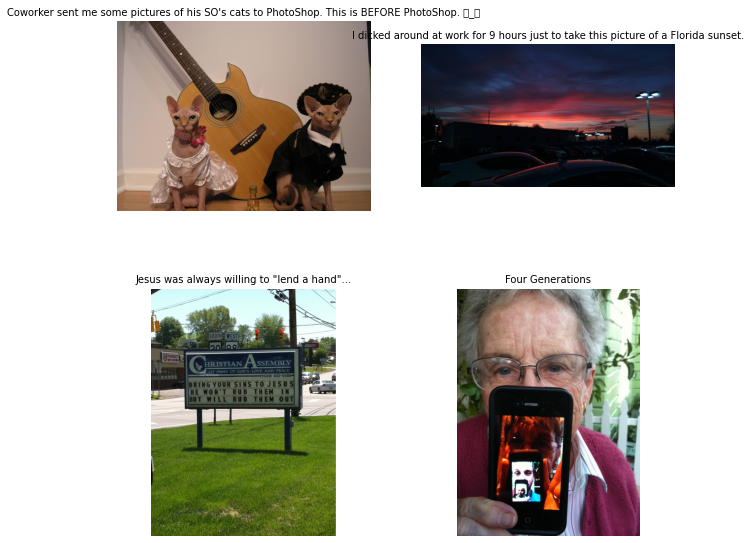

In [ ]:
# 8
for idx, row in output_df[8:9].iterrows():
    image_list = [row['id']] + row['pred'].tolist()
    title_list = []
    for image in image_list:
        title_list.append(df.loc[df['id']==image]['caption'].tolist()[0])
    print(image_list)
    plot(image_list, title_list)
    

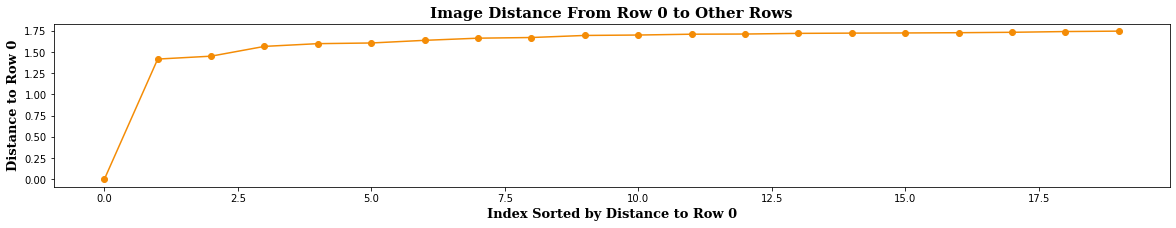

         id
0     hs8ix
126   itiwg
168   koaa1
298   pkya8
129  1s2ywj
265  14tl76
256   tapol
244  1k6brm
196  19t9km
117   pcd5p


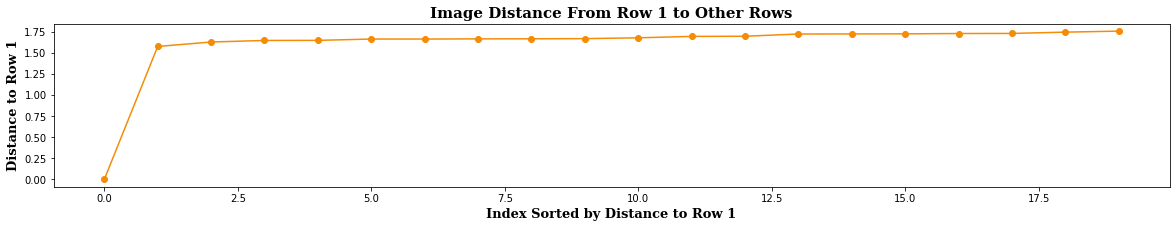

         id
1    1auy9l
244  1k6brm
71   15iocz
69   15appj
78    zjtcg
5    1ftvv4
43   1o7tcj
46    ijlh7
164   kzvt5
40    bzi9u


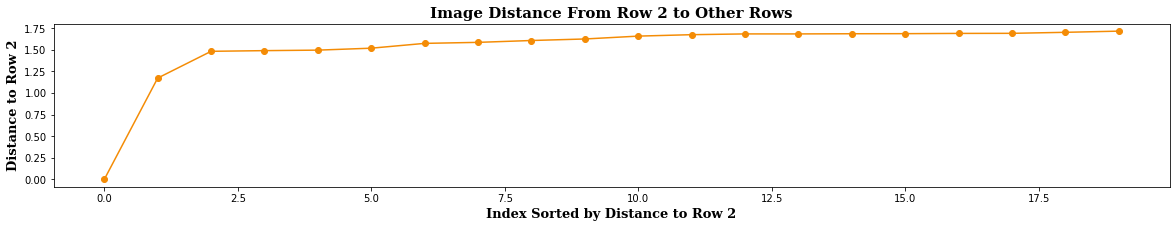

         id
2     llnzx
51    wkodb
240  12kta4
5    1ftvv4
157   icc2f
282   h7lyc
175  12f9z4
125   npp93
215  1ns543
156  1lpu6c


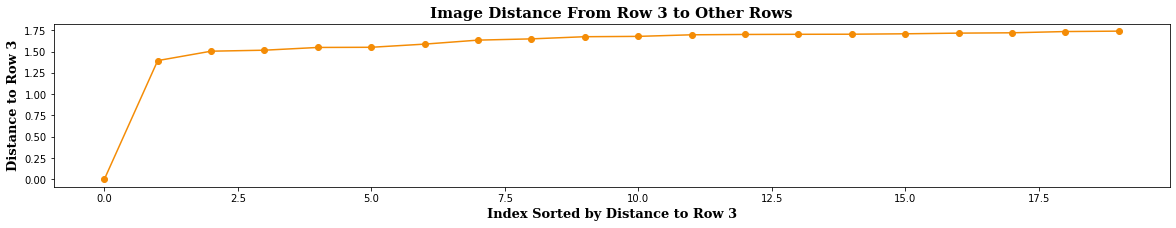

         id
3    1pkkx9
269  1pl3za
287   emn67
36    kqfsy
236   vtpj4
192   icmmj
135   xpo4o
244  1k6brm
233   zlttp
107  1fzvhk


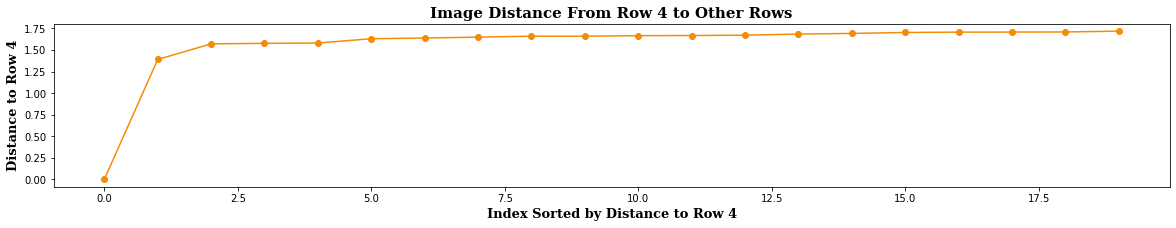

         id
4    1t94in
192   icmmj
130   lwvb4
125   npp93
294  1lhsfn
247  1udc8x
296  10y05f
40    bzi9u
95   1nnj4m
183   uw624


In [ ]:
import matplotlib.pyplot as plt

for k in range(5):
    plt.figure(figsize=(20,3))                 
    plt.plot(np.arange(20), distances[k,:20].tolist(),'o-',color='#f48c06')
    plt.title('Image Distance From Row %i to Other Rows'%k,fontsize=15, fontweight='bold',horizontalalignment='center',fontfamily='serif')
    plt.ylabel('Distance to Row %i'%k,fontsize=13, fontweight='bold',fontfamily='serif')
    plt.xlabel('Index Sorted by Distance to Row %i'%k,fontsize=13, fontweight='bold',fontfamily='serif')
    plt.show()
    
    print(df_for_model.loc[indices[k,:10].tolist(),['id']] )
    

# <font color=gray> Ensembling  </font> 

# <font color=gray> Sorting  </font> 